# Figure 2

> Simulated evolution of the Sun's mass and radius (orange solid  curves), and Earth's semi-major axis (blue dashed curve), for approximately 4 Myr before the tip of the RGB phase.  In this test, Earth's orbital radius started exactly at 1 AU.

For more information and additional explanation of the code in this notebook, see the official REBOUNDx effect example documentation for ["Parameter Interpolation"](https://github.com/dtamayo/reboundx/blob/master/ipython_examples/ParameterInterpolation.ipynb).

## Load

We first load in the extracted data, exported from MESA log files, as done in [mesa2txt.ipynb](https://github.com/sabaronett/REBOUNDxPaper/blob/master/mesa2txt.ipynb).

In [1]:
import numpy as np

data = np.loadtxt('m.txt') # return (N, 2) array
mtimes = data[:, 0]        # return only 1st col
masses = data[:, 1]        # return only 2nd col

data = np.loadtxt('r.txt')
rtimes = data[:, 0]
Rsuns = data[:, 1]         # data in Rsun units

# convert Rsun to AU
radii = np.zeros(Rsuns.size)
for i, r in enumerate(Rsuns):
    radii[i] = r * 0.00465047

## Setup
Next we set up the Sun-Earth system.

In [2]:
import rebound
import reboundx

M0 = 0.8645388227818771 # initial mass of star
R0 = 0.3833838293200158 # initial radius of star

def makesim():
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2               # use units of AU, yrs and solar masses
    sim.add(m=M0, r=R0, hash='Star')
    sim.add(a=1., hash='Earth')
    sim.collision = 'direct'         # check if RGB Sun engulfs Earth
    sim.integrator = 'whfast'
    sim.dt = 0.1*sim.particles[1].P
    sim.move_to_com()
    return sim

Now we can create an `Interpolator` object for each parameter set and pass the corresponding arrays as arguments.

In [3]:
sim = makesim()
ps = sim.particles
rebx = reboundx.Extras(sim)
starmass = reboundx.Interpolator(rebx, mtimes, masses, 'spline')
starradius = reboundx.Interpolator(rebx, rtimes, radii, 'spline')

## Run

We integrate for 4 Myr, updating the central body's mass and radius interpolated at the time between outputs.

In [4]:
%%time
Nout = 1000
mass = np.zeros(Nout)
radius = np.zeros(Nout)
a = np.zeros(Nout)
ts = np.linspace(0., 4.e6, Nout)
T0 = 1.23895e10 # Sun's age at simulation start

for i, time in enumerate(ts):
    sim.integrate(time)
    ps[0].m = starmass.interpolate(rebx, t=T0+sim.t)
    ps[0].r = starradius.interpolate(rebx, t=T0+sim.t)
    sim.move_to_com() # lost mass had momentum, so need to move back to COM frame
    mass[i] = sim.particles[0].m
    radius[i] = sim.particles[0].r
    a[i] = sim.particles[1].a

CPU times: user 17.6 s, sys: 8.96 ms, total: 17.6 s
Wall time: 17.6 s


## No Interpolation

We rerun the simulation but this time without any parameter interpolation.  Instead we simply update the stellar parameters at each raw MESA output.

Since we want to integrate over the same 4 Myr window, we must inspect the input files (e.g., `m.txt` and `r.txt`) to identify the closest indices (accounting for zero-offset) that span the 4 Myr range we wish to replicate.

To make the code simpler, we first copy slices of our parameter input arrays.  Since the sliced time series normally starts >12 Gyr, we subtract all its elements by `T0`.

In [5]:
start = 552                    # line 553 in m/r.txt
end = 4867                     # line 4868 in m/r.txt
tsNPI = mtimes[start:end] - T0 # NPI = 'no parameter interpolation'
massesNPI = masses[start:end]
radiiNPI = radii[start:end]
Nout = end - start
aNPI = np.zeros(Nout)

In [6]:
%%time
sim = makesim()
ps = sim.particles

for i,time in enumerate(tsNPI):
    sim.move_to_com()
    sim.integrate(time)
    ps[0].m = massesNPI[i]
    ps[0].r = radiiNPI[i]
    aNPI[i] = sim.particles[1].a

CPU times: user 16.4 s, sys: 10 ms, total: 16.4 s
Wall time: 16.4 s


## Plot

We plot the Sun's mass over time, and a comparison of the Sun's radius and Earth's semi-major axis over time, adjacent to one another.

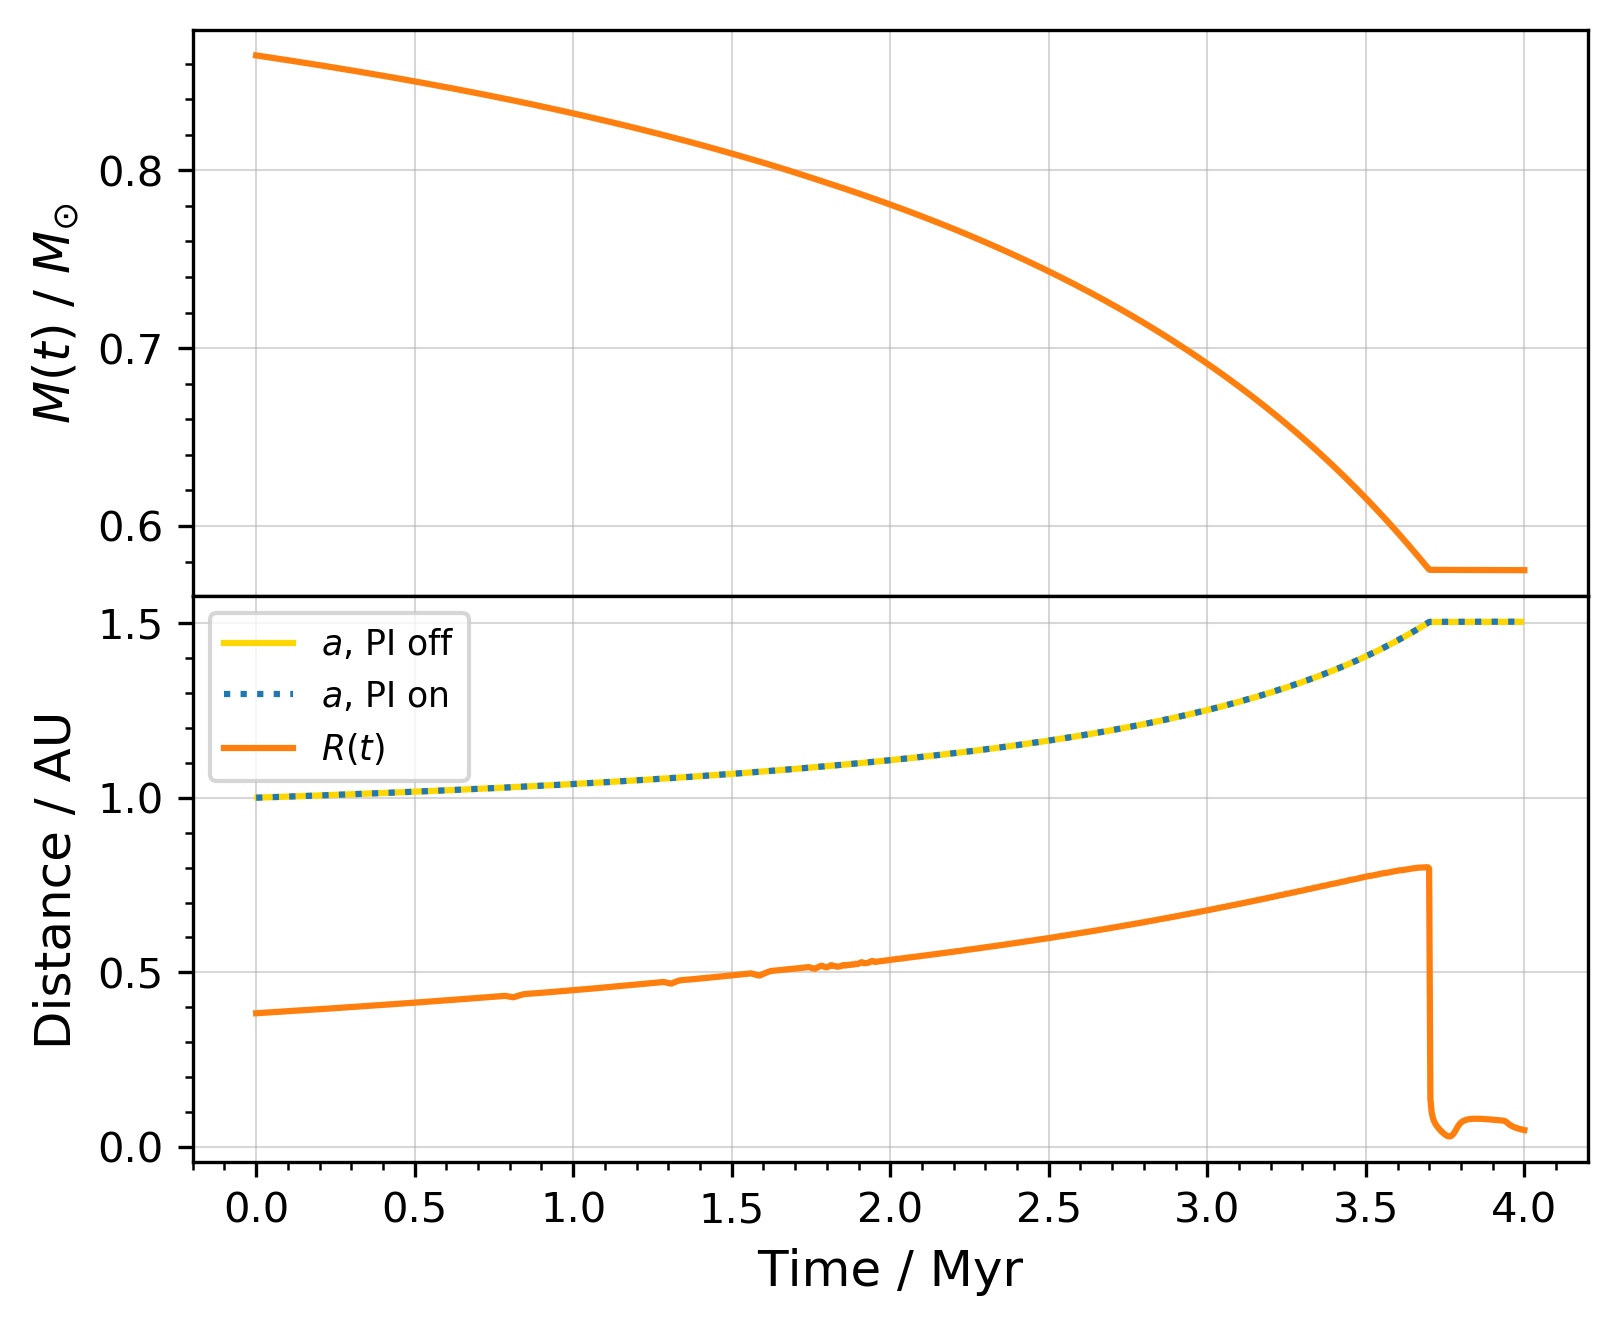

In [7]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(6, 5),
                               dpi=300)
fig.subplots_adjust(hspace=0)

ax1.set_ylabel("$M(t)$ / $M_{\odot}$", fontsize='large')
ax1.yaxis.set_minor_locator(mticker.AutoMinorLocator())
ax1.plot(ts/1e6,mass, color='tab:orange')
ax1.grid(lw=.5, alpha=.5)

ax2.set_xlabel('Time / Myr', fontsize='large')
ax2.xaxis.set_minor_locator(mticker.AutoMinorLocator())
ax2.set_ylabel('Distance / AU', fontsize='large')
ax2.yaxis.set_minor_locator(mticker.AutoMinorLocator())
ax2.plot(tsNPI/1e6,aNPI, color='gold', label='$a$, PI off')
ax2.plot(ts/1e6,a, ':', color='tab:blue', label='$a$, PI on')
ax2.plot(ts/1e6,radius, color='tab:orange', label='$R(t)$')
ax2.legend(fontsize='small', loc='upper left')
ax2.grid(lw=.5, alpha=.5)

# plt.savefig('img/fig2.png')